In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Guo et al. (2009) galaxy size measurements

In [7]:
# load 'centrals' galaxy tables

from astropy.table import Table
fpath = './mnras0398-1129-sm_TableB1/'
fname = 'mnr15223_tableb1.dat'
names = ['ID', 'RA', 'DEC', 'Mag', 'a50', 'n', 'b/a', 'PA', 'Sky',
         'chi^2', 'z', 'Mr', 'Mstar', 'r50', 'g-r', 'Mhalo', 'Visual type']
t_1 = Table.read(fpath+fname, format='ascii', names=names)

# Linear Regression Model for Median Size

In [113]:
from sklearn.linear_model import LinearRegression

## Elliptical Galaxies

In [114]:
mask = ellipticals & (t_1['r50']>0.0)
m = np.array(t_1['Mr'][mask]).reshape((np.sum(mask),1))
r = np.array(t_1['r50'][mask]).reshape((np.sum(mask),1))
reg = LinearRegression().fit(m, np.log10(r))

In [116]:
intercept = reg.intercept_[0]
slope = reg.coef_[0][0]/0.4
print('m=', slope)
print('b=', intercept)

def elliptical_size_model(mag, m=slope, b=intercept):
    """
    model for galaxy size
    """
    return 10**(0.4*m*mag + b)

m= -1.03685551832852
b= -8.193093038010682


## Disk Galaxies

In [117]:
mask = disks & (t_1['r50']>0.0)
m = np.array(t_1['Mr'][mask]).reshape((np.sum(mask),1))
r = np.array(t_1['r50'][mask]).reshape((np.sum(mask),1))
reg = LinearRegression().fit(m, np.log10(r))

In [118]:
intercept = reg.intercept_[0]
slope = reg.coef_[0][0]/0.4
print('m=', slope)
print('b=', intercept)

def disk_size_model(mag, m=slope, b=intercept):
    """
    model for galaxy size
    """
    return 10**(0.4*m*mag + b)

m= -0.8102661650155903
b= -6.186308931086971


# fit Scatter Model

## Elliptical Galaxies

In [143]:
nboot = 10000
nbins = len(mag_bins)-1

sizes = np.zeros((nbins,nboot))
scatters = np.zeros((nbins,nboot))

for i in range(0,nbins):
    mask = (t_1['Mr']<=mag_bins[i]) & (t_1['Mr']>mag_bins[i+1]) & ellipticals
    r = t_1['r50'][mask]
    model_s = elliptical_size_model(mag_bin_centers[i])
    for j in range(0,nboot):
        rr = np.random.choice(r, size=len(r), replace=True)
        result = lognorm.fit(rr, floc=0.0, fscale=model_s)
        scatters[i,j] = result[0]
        result = lognorm.fit(rr, floc=0.0)
        sizes[i,j] = result[2]

elliptical_scatters_err = np.std(scatters, axis=1)
elliptical_scatters = np.mean(scatters, axis=1)

median_elliptical_sizes = np.mean(sizes, axis=1)
elliptical_sizes_err = np.std(sizes, axis=1)

In [156]:
mean_elliptical_scatter = np.average(elliptical_scatters, weights=1.0/elliptical_scatters_err)
print(mean_elliptical_scatter)

0.38002679456580557


## Disk Galaxies

In [145]:
nboot = 10000
nbins = len(mag_bins)-1

sizes = np.zeros((nbins,nboot))
scatters = np.zeros((nbins,nboot))

for i in range(0,nbins):
    mask = (t_1['Mr']<=mag_bins[i]) & (t_1['Mr']>mag_bins[i+1]) & disks
    r = t_1['r50'][mask]
    model_s = disk_size_model(mag_bin_centers[i])
    for j in range(0,nboot):
        rr = np.random.choice(r, size=len(r), replace=True)
        result = lognorm.fit(rr, floc=0.0, fscale=model_s)
        scatters[i,j] = result[0]
        result = lognorm.fit(rr, floc=0.0)
        sizes[i,j] = result[2]

disk_scatters_err = np.std(scatters, axis=1)
disk_scatters = np.mean(scatters, axis=1)

median_disk_sizes = np.mean(sizes, axis=1)
disk_sizes_err = np.std(sizes, axis=1)

In [155]:
mean_disk_scatter = np.average(disk_scatters, weights=1.0/disk_scatters_err)
print(mean_disk_scatter)

0.3865038283378544


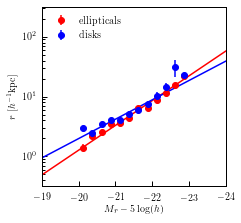

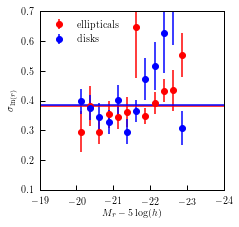

In [154]:
m_sample = np.linspace(-19,-24,1000)

plt.figure(figsize=(3.3,3.3))
p1 = plt.errorbar(mag_bin_centers, median_elliptical_sizes,
             yerr=elliptical_sizes_err, fmt='o', color='red')
p2 = plt.errorbar(mag_bin_centers, median_disk_sizes,
             yerr=disk_sizes_err, fmt='o', color='blue')
l1, = plt.plot(m_sample, elliptical_size_model(m_sample), color='red')
l2, = plt.plot(m_sample, disk_size_model(m_sample), color='blue')
plt.xlim([-19,-24])
plt.ylim([10**(-0.5),10**2.5])
plt.yscale('log')
plt.legend([p1,p2],['ellipticals','disks'], frameon=False, loc='upper left', fontsize=10)
plt.xlabel(r'$M_r - 5\log(h)$')
plt.ylabel(r'$r~[h^{-1}{\rm kpc}]$')
plt.show()

plt.figure(figsize=(3.3,3.3))
plt.errorbar(mag_bin_centers, elliptical_scatters,
             yerr=elliptical_scatters_err, fmt='o', color='red')
plt.errorbar(mag_bin_centers, disk_scatters,
             yerr=disk_scatters_err, fmt='o', color='blue')
plt.plot(m_sample, m_sample*0.0+mean_elliptical_scatter, color='red')
plt.plot(m_sample, m_sample*0.0+mean_disk_scatter, color='blue')
plt.xlim([-19,-24])
plt.ylim([0.1,0.7])
plt.legend([p1,p2],['ellipticals','disks'], frameon=False, loc='upper left', fontsize=10)
plt.xlabel(r'$M_r - 5\log(h)$')
plt.ylabel(r'$\sigma_{\ln(r)}$')
plt.show()